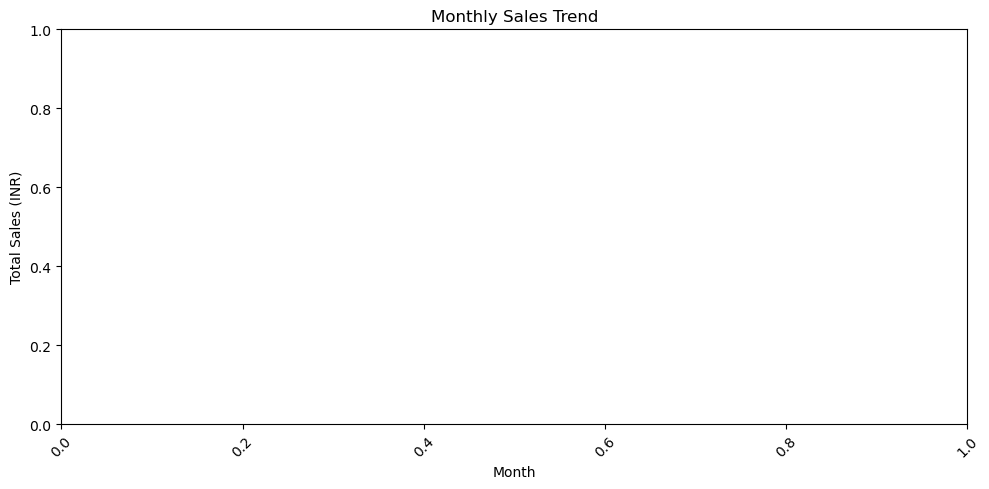

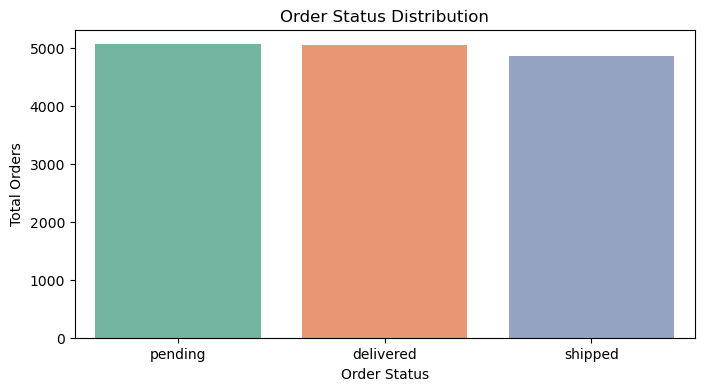

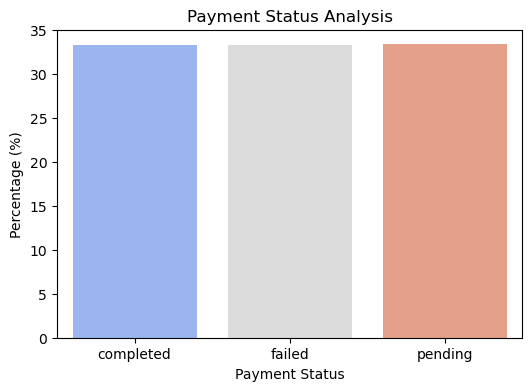

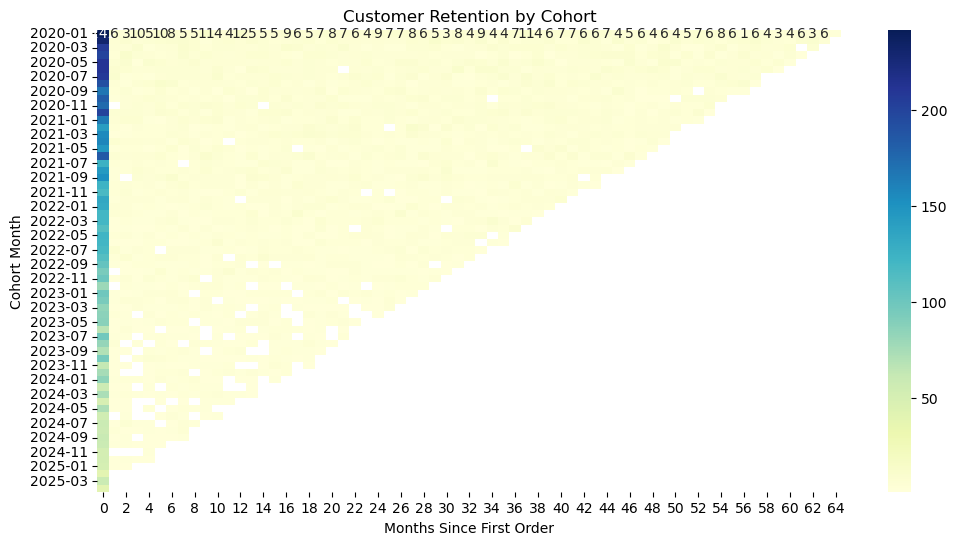

Fulfillment Rate (%)
   fulfillment_rate_percentage
0                          0.0
Top Repeat Customers
Empty DataFrame
Columns: [customer_id, completed_orders]
Index: []
Failed Payments
                             payment_id  customer_id  \
0  cb2192b6-7aaa-4cd4-aae0-90b50ef57be9         6899   
1  b56adedf-df4a-4548-b71f-8a42ebad658e         3999   
2  2afb4a6b-c109-4bce-a5ea-8df6523f62ea         7772   
3  848e5a46-0105-47b5-b738-81722abdc340         6314   
4  7d0096d9-8a0a-4507-b6d4-5075de4e4f9e         4570   

                               order_id  order_amount payment_status  
0  6f3c08c4-c069-4d08-987b-cc00bca479cd        178.89         failed  
1  62ff4cc5-fc6f-4060-871b-2d0c22e16c10        192.92         failed  
2  9e502873-c481-4334-81a0-f94238d7a510        317.18         failed  
3  6d2e3351-68c2-4e5f-86a9-19f0af5bb7ad        490.89         failed  
4  1ac86c52-2fa4-4c08-9b75-6da5b68ae87e        200.07         failed  


In [2]:
# 1. Import Libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Data (replace these with actual CSVs)
customer_orders = pd.read_csv('customer_orders.csv')
payments = pd.read_csv('payments.csv')

# 3. Create SQLite Database in Memory
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

customer_orders.to_sql('customer_orders', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')

# 4. SQL Queries

## 4.1 Order and Sales Analysis
# Order Status Count
order_status = pd.read_sql_query('''
    SELECT order_status, COUNT(*) as total_orders
    FROM customer_orders
    GROUP BY order_status
    ORDER BY total_orders DESC;
''', conn)
# Monthly Sales Trend
sales_trend = pd.read_sql_query('''
    SELECT strftime('%Y-%m', order_date) as month, SUM(order_amount) as total_sales
    FROM customer_orders
    WHERE order_status = 'completed'  
    GROUP BY month
    ORDER BY month;
''', conn)


# Fulfillment Rate
fulfillment = pd.read_sql_query('''
    SELECT 
      (COUNT(CASE WHEN order_status = 'completed' THEN 1 END) * 100.0) / COUNT(*) AS fulfillment_rate_percentage
    FROM customer_orders;
''', conn)

## 4.2 Customer Analysis
# Repeat Customers
repeat_customers = pd.read_sql_query('''
    SELECT customer_id, COUNT(*) as completed_orders
    FROM customer_orders
    WHERE order_status = 'completed'  
    GROUP BY customer_id
    HAVING COUNT(*) > 1
    ORDER BY completed_orders DESC;
''', conn)

## 4.3 Payment Status Analysis
payment_status = pd.read_sql_query('''
    SELECT payment_status, COUNT(*) as total_payments,
           ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM payments), 2) AS percentage
    FROM payments
    GROUP BY payment_status;
''', conn)

failed_payments = pd.read_sql_query('''
    SELECT p.payment_id, c.customer_id, c.order_id, c.order_amount, p.payment_status 
    FROM payments p
    JOIN customer_orders c ON p.order_id = c.order_id
    WHERE p.payment_status = 'failed';
''', conn)

## 4.4 Order Details Report
order_details = pd.read_sql_query('''
    SELECT c.order_id, c.customer_id, c.order_date, c.order_status,  
           c.order_amount, p.payment_id, p.payment_date, 
           p.payment_status, p.payment_amount
    FROM customer_orders c
    LEFT JOIN payments p ON c.order_id = p.order_id
    ORDER BY c.order_date;
''', conn)

## 4.5 Cohort Analysis for Retention
cohort_analysis = pd.read_sql_query('''
    WITH first_orders AS (
      SELECT customer_id, MIN(order_date) AS first_order_date
      FROM customer_orders
      GROUP BY customer_id
    )
    SELECT 
      strftime('%Y-%m', f.first_order_date) AS cohort_month,
      strftime('%Y-%m', c.order_date) AS order_month,
      CAST((julianday(c.order_date) - julianday(f.first_order_date))/30 AS INT) AS months_since_first_order,
      COUNT(DISTINCT c.customer_id) AS retained_customers
    FROM customer_orders c
    JOIN first_orders f ON c.customer_id = f.customer_id
    GROUP BY cohort_month, order_month, months_since_first_order
    ORDER BY cohort_month, months_since_first_order;
''', conn)

# 5. Visualizations

## 5.1 Sales Trend Over Time
plt.figure(figsize=(10,5))
sns.lineplot(data=sales_trend, x='month', y='total_sales', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.2 Order Status Distribution
plt.figure(figsize=(8,4))
sns.barplot(data=order_status, x='order_status', y='total_orders', palette='Set2') 
plt.title('Order Status Distribution')
plt.xlabel('Order Status')
plt.ylabel('Total Orders')
plt.show()

## 5.3 Payment Success vs Failure
plt.figure(figsize=(6,4))
sns.barplot(data=payment_status, x='payment_status', y='percentage', palette='coolwarm')
plt.title('Payment Status Analysis')
plt.ylabel('Percentage (%)')
plt.xlabel('Payment Status')
plt.show()

# 5.4 Customer Retention Heatmap
cohort_pivot = cohort_analysis.pivot_table(index="cohort_month", 
                                         columns="months_since_first_order", 
                                         values="retained_customers", 
                                         aggfunc='sum') 
plt.figure(figsize=(12,6))
# Change the format code to '.0f' or 'g' to handle floats:
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu')  
plt.title('Customer Retention by Cohort')
plt.xlabel('Months Since First Order')
plt.ylabel('Cohort Month')
plt.show()

# 6. Summary Output
print("Fulfillment Rate (%)")
print(fulfillment)

print("Top Repeat Customers")
print(repeat_customers.head())

print("Failed Payments")
print(failed_payments.head())

# Done!


In [5]:
import pandas as pd
import sqlite3

# Step 1: Load CSVs
orders = pd.read_csv('customer_orders.csv')
payments = pd.read_csv('payments.csv')

# Step 2: Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Step 3: Upload dataframes into SQL tables
orders.to_sql('customer_orders', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')

# Now SQL queries!

# Task 1: Order and Sales Analysis
print("\n--- Order Status Distribution ---")
query1 = """
SELECT order_status, COUNT(*) AS total_orders
FROM customer_orders
GROUP BY order_status
ORDER BY total_orders DESC;
"""
print(pd.read_sql_query(query1, conn))

print("\n--- Total Sales ---")
query2 = """
SELECT SUM(order_amount) AS total_sales
FROM customer_orders;
"""
print(pd.read_sql_query(query2, conn))

print("\n--- Monthly Sales Trend ---")
query3 = """
SELECT substr(order_date, 1, 7) AS month, SUM(order_amount) AS monthly_sales
FROM customer_orders
GROUP BY month
ORDER BY month;
"""
print(pd.read_sql_query(query3, conn))


# Task 2: Customer Analysis
print("\n--- Total Orders Per Customer ---")
query4 = """
SELECT customer_id, COUNT(order_id) AS total_orders
FROM customer_orders
GROUP BY customer_id
ORDER BY total_orders DESC;
"""
print(pd.read_sql_query(query4, conn))

print("\n--- Repeat Customers ---")
query5 = """
SELECT customer_id
FROM customer_orders
GROUP BY customer_id
HAVING COUNT(order_id) > 1;
"""
print(pd.read_sql_query(query5, conn))

print("\n--- New vs Repeat Customers Monthly ---")
query6 = """
WITH customer_order_ranks AS (
    SELECT customer_id, order_date,
           RANK() OVER (PARTITION BY customer_id ORDER BY order_date) AS order_rank
    FROM customer_orders
)
SELECT substr(order_date, 1, 7) AS month,
       SUM(CASE WHEN order_rank = 1 THEN 1 ELSE 0 END) AS new_customers,
       SUM(CASE WHEN order_rank > 1 THEN 1 ELSE 0 END) AS repeat_customers
FROM customer_order_ranks
GROUP BY month
ORDER BY month;
"""
print(pd.read_sql_query(query6, conn))


# Task 3: Payment Status Analysis
print("\n--- Payment Status Counts ---")
query7 = """
SELECT payment_status, COUNT(*) AS status_count
FROM payments
GROUP BY payment_status;
"""
print(pd.read_sql_query(query7, conn))

print("\n--- Failed Payments Details ---")
query8 = """
SELECT *
FROM payments
WHERE payment_status = 'failed';
"""
print(pd.read_sql_query(query8, conn))


# Task 4: Order Details Report
print("\n--- Order + Payment Detailed Report ---")
query9 = """
SELECT
    o.order_id,
    o.customer_id,
    o.order_date,
    o.order_amount,
    o.order_status,
    p.payment_id,
    p.payment_date,
    p.payment_amount,
    p.payment_method,
    p.payment_status
FROM customer_orders o
LEFT JOIN payments p
ON o.order_id = p.order_id;
"""
order_payment_report = pd.read_sql_query(query9, conn)
print(order_payment_report.head())

# Optional: Save the detailed report to a CSV
order_payment_report.to_csv('order_payment_report.csv', index=False)

# Close the connection
conn.close()



--- Order Status Distribution ---
  order_status  total_orders
0      pending          5069
1    delivered          5057
2      shipped          4874

--- Total Sales ---
   total_sales
0   3808899.19

--- Monthly Sales Trend ---
      month  monthly_sales
0   2020-01       60638.78
1   2020-02       61461.48
2   2020-03       54706.72
3   2020-04       56073.18
4   2020-05       58426.84
..      ...            ...
59  2024-12       57256.38
60  2025-01       58413.77
61  2025-02       57557.77
62  2025-03       64379.46
63  2025-04       57148.69

[64 rows x 2 columns]

--- Total Orders Per Customer ---
      customer_id  total_orders
0            2633             8
1            9955             7
2            9476             7
3            9243             7
4            8231             7
...           ...           ...
7329         1022             1
7330         1014             1
7331         1011             1
7332         1007             1
7333         1002             1

[7